In [1]:
import gensim
from gensim.models import fasttext, KeyedVectors, Word2Vec
import gensim.downloader as api
#api.info()
from gensim.test.utils import datapath
import pandas as pd
#from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

from pathlib import Path
from germanetpy.germanet import Germanet

## Load FastText model 

In [4]:
cd ../ms_data

/Users/olcia/Desktop/ms_data


In [5]:
%%time
#cap_path = datapath("cc.de.300.bin")
wv = fasttext.load_facebook_vectors("cc.de.300.bin")

CPU times: user 26.7 s, sys: 4.34 s, total: 31.1 s
Wall time: 42.9 s


## Load GermaNet 

In [6]:
cd 

/Users/olcia


In [7]:
cd Desktop/ms_data/GN_V180

/Users/olcia/Desktop/ms_data/GN_V180


In [8]:
from germanetpy.germanet import Germanet
from germanetpy.frames import Frames
from germanetpy.filterconfig import Filterconfig
from germanetpy.synset import WordCategory, WordClass

#germanet_object = germanet.Germanet("GN_V180_XML")

germanet = Germanet("GN_V180_XML")

Load GermaNet data...: 100%|█████████▉| 99.99999999999996/100 [00:04<00:00, 23.38it/s] 
Load Wictionary data...: 100%|██████████| 100.0/100 [00:00<00:00, 1250.99it/s]
Load Ili records...: 100%|██████████| 100.0/100 [00:00<00:00, 167839.30it/s]


In [9]:
def find_compounds(item, germanet):
    # Define a Filterconfig to filter words that end with 'item' or begin with 'item'
    filterconfig = (Filterconfig(f'({item}.*|.*{item})', regex=True, ignore_case=True))
    filterconfig.word_categories = [WordCategory.nomen]
    
    # Filter Germanet objects
    result = filterconfig.filter_lexunits(germanet)
    
    # Check if the result is empty, and if so, return an empty DataFrame
    if not result:
        return pd.DataFrame()

    # Extract 'orthform' from Lexunit objects
    ids = [lexunit.id for lexunit in result]
    
    # Create a DataFrame from the 'orthform' column
    df = pd.DataFrame({'id': ids})
    
    # Retrieve lexunit information by id and create the 'compound' column
    df['compound'] = df['id'].apply(lambda x: germanet.get_lexunit_by_id(x).compound_info if germanet.get_lexunit_by_id(x) else None) 
    # Extract 'modifier' and 'head' columns
    df['modifier'] = df['compound'].apply(lambda x: re.search(r'modifier = (\w+)', str(x)).group(1) if re.search(r'modifier = (\w+)', str(x)) else None)
    df['head'] = df['compound'].apply(lambda x: re.search(r'head = (\w+)', str(x)).group(1) if re.search(r'head = (\w+)', str(x)) else None)

    # Create a new column to store values not equal to item in 'modifier' and 'head' columns
    df['non_item'] = None

    # Check if values in 'modifier' column are not equal to item, store them in 'non_item' column
    df.loc[df['modifier'] != item, 'non_item'] = df['modifier']

    # Check if values in 'head' column are not equal to item, store them in 'non_item' column
    df.loc[df['head'] != item, 'non_item'] = df['head']

    # Drop rows where either 'modifier' or 'head' is None
    df = df.dropna(subset=['modifier', 'head'])

    # Drop rows where either 'modifier' or 'head' is not equal to item
    df = df[(df[modifier] == item) | (df[head] == item)]

    return df


In [10]:
def find_common_and_values_in_two_tables(result_df1, result_df2, result_df3):
    # Check for common values in the "non_item" column
    common_values = set(result_df1[non_item]) & set(result_df2[non_item]) & set(result_df3[non_item'])
    
    # Find common values in pairs of dataframes
    common_values_df1_df2 = set(result_df1['non_item']) & set(result_df2['non_item'])
    common_values_df1_df3 = set(result_df1['non_item']) & set(result_df3['non_item'])
    common_values_df2_df3 = set(result_df2['non_item']) & set(result_df3['non_item'])
    
    # Find values that occur in exactly two out of the three dataframes
    values_in_two_tables = (common_values_df1_df2 | common_values_df1_df3 | common_values_df2_df3) - (common_values_df1_df2 & common_values_df1_df3 & common_values_df2_df3)

    # Create a table to show values occurring in exactly two tables and the corresponding tables
    result_table = pd.DataFrame(columns=['Value', 'Tables'])
    for value in values_in_two_tables:
        tables = []
        if value in common_values_df1_df2: 
            tables.append('cue1 and cue2')
        if value in common_values_df1_df3:
            tables.append('cue1 and cue3')
        if value in common_values_df2_df3:
            tables.append('cue2 and cue3')
        result_table = pd.concat([result_table, pd.DataFrame({'Value': [value], 'Tables': [', '.join(tables)]})], ignore_index=True)

    # Return results as DataFrame
    return common_values, result_table

## Load results and correct answers

In [11]:
cd 

/Users/olcia


In [12]:
cd Desktop/ms_data

/Users/olcia/Desktop/ms_data


In [13]:
ans = pd.read_excel("ALL_v2.xlsx", sheet_name=0)
ans.head()

,Participant ID,Condition,RAT item,RT,Response
0,f2b31ae7802d6acebf334468f14c2e59,Hightech,1,10463,Jacke
1,f2b31ae7802d6acebf334468f14c2e59,Hightech,2,8792,Schrank
2,f2b31ae7802d6acebf334468f14c2e59,Hightech,3,5695,Ziel
3,f2b31ae7802d6acebf334468f14c2e59,Hightech,4,13271,Pflanze
4,f2b31ae7802d6acebf334468f14c2e59,Hightech,5,13117,Technik


In [14]:
ans1p = pd.read_excel("ALL_v2.xlsx", sheet_name=0)

In [15]:
correct = pd.read_csv("RATtemauswahl.csv", encoding="utf-8")
correct.head()

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",item,correct answer
0,1,RAT_19,33,Pelz - Tasche - Schutz,Mantel
1,2,RAT_1,9,Kaffee - Schnabel - Porzellan,Tasse
2,3,RAT_7,31,Plan - Rundfahrt - Rat,Stadt
3,4,RAT_13,57,Natur - Tüte - Welt,Wunder
4,5,RAT_2,15,Programm - Virus - Kurs,Computer


In [16]:
table1 = pd.read_csv("RATtemauswahl.csv", encoding="utf-8")
table1.head()

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",item,correct answer
0,1,RAT_19,33,Pelz - Tasche - Schutz,Mantel
1,2,RAT_1,9,Kaffee - Schnabel - Porzellan,Tasse
2,3,RAT_7,31,Plan - Rundfahrt - Rat,Stadt
3,4,RAT_13,57,Natur - Tüte - Welt,Wunder
4,5,RAT_2,15,Programm - Virus - Kurs,Computer


In [17]:
#split items into seperate columns
correct[['item1','item2','item3' ]] = correct['item'].str.split(' - ',expand=True)

In [18]:
#drop item
correct = correct.drop(columns='item')

In [19]:
#remove the space a the end
correct['item3'] = correct['item3'].apply(lambda x: x.strip())

In [20]:
#need to automatize
correct.loc[3, 'item2'] = 'Tüte'
correct.loc[16, 'item3'] = 'Gefäß'
correct.loc[17, 'item1'] = 'König'

In [130]:
correct.head(8)

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",correct answer,item1,item2,item3,answers,2outof3
0,1,RAT_19,33,Mantel,Pelz,Tasche,Schutz,"Mantel, Jacke","Werk, Weste, Tier, Diebstahl, Bekleidung, Gürt..."
1,2,RAT_1,9,Tasse,Kaffee,Schnabel,Porzellan,Tasse,"Service, Geschirr, Becher, Kanne, Geschäft"
2,3,RAT_7,31,Stadt,Plan,Rundfahrt,Rat,Stadt,"Krieg, Personal, Börse, bauen, Insel, Frieden,..."
3,4,RAT_13,57,Wunder,Natur,Tüte,Welt,Wunder,"Gesetz, Erlebnis, Bad, Bühne, Raum, Gefühl, Mu..."
4,5,RAT_2,15,Computer,Programm,Virus,Kurs,Computer,"Ferien, Kunst, aufbauen, Ausbildung, Musik, Ki..."
5,6,RAT_8,18,Kugel,Welt,Hagel,Billard,Kugel,"Raum, Spiel, Sport"
6,7,RAT_14,59,Straße,Schild,Bahn,Bau,"Brücke, Wald, Holz, Nummer, rund, Straße, Auto","Werk, Hof, Zelt, Metall, haupt, Leitung, Preis..."
7,8,RAT_3,35,Test,Elch,Aids,Pilot,Test,


## Preperation

#### a. Get all of the possible answers with GermaNet to the answers column and alternatives in 2outof3 column

In [22]:
#iterate over each row in the "correct" table
for index, row in correct.iterrows():
    # Apply the function to each item column
    result_df1 = find_compounds(row['item1'], germanet)
    result_df2 = find_compounds(row['item2'], germanet)
    result_df3 = find_compounds(row['item3'], germanet)
    
    #use the second function to find common values and create a new column
    common_values, result_table = find_common_and_values_in_two_tables(result_df1, result_df2, result_df3)
      #update the "answers" column in the "correct" table with common values
    correct.at[index, 'answers'] = ', '.join(common_values)
    correct.at[index, '2outof3'] = ', '.join(result_table['Value'])

In [23]:
result_df3

,id,compound,modifier,head,non_item
0,l38214,"CompoundInfo( modifier = Chor, head = Probe)",Chor,Probe,Chor
1,l166667,"CompoundInfo( modifier = Luft, head = Probe)",Luft,Probe,Luft
2,l190696,"CompoundInfo( modifier = stellen, head = Probe)",stellen,Probe,stellen
3,l118901,"CompoundInfo( modifier = Probe, head = Flug)",Probe,Flug,Flug
4,l191111,"CompoundInfo( modifier = Probe, head = Studium)",Probe,Studium,Studium
...,...,...,...,...,...
132,l205381,"CompoundInfo( modifier = Probe, head = Tag)",Probe,Tag,Tag
133,l187086,"CompoundInfo( modifier = Bier, head = Probe)",Bier,Probe,Bier
134,l214268,"CompoundInfo( modifier = Probe, head = Behälter)",Probe,Behälter,Behälter
135,l184381,"CompoundInfo( modifier = Probe, head = Fahren)",Probe,Fahren,Fahren


In [137]:
# Finding compounds in 
#find_compounds('rund', germanet)
germanet.get_lexunit_by_id("l120275")


Lexunit(id=l120275, orthform=Rundschild, synset_id=s89490)

In [24]:
correct

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",correct answer,item1,item2,item3,answers,2outof3
0,1,RAT_19,33,Mantel,Pelz,Tasche,Schutz,"Mantel, Jacke","Werk, Weste, Tier, Diebstahl, Bekleidung, Gürt..."
1,2,RAT_1,9,Tasse,Kaffee,Schnabel,Porzellan,Tasse,"Service, Geschirr, Becher, Kanne, Geschäft"
2,3,RAT_7,31,Stadt,Plan,Rundfahrt,Rat,Stadt,"Krieg, Personal, Börse, bauen, Insel, Frieden,..."
3,4,RAT_13,57,Wunder,Natur,Tüte,Welt,Wunder,"Gesetz, Erlebnis, Bad, Bühne, Raum, Gefühl, Mu..."
4,5,RAT_2,15,Computer,Programm,Virus,Kurs,Computer,"Ferien, Kunst, aufbauen, Ausbildung, Musik, Ki..."
5,6,RAT_8,18,Kugel,Welt,Hagel,Billard,Kugel,"Raum, Spiel, Sport"
6,7,RAT_14,59,Straße,Schild,Bahn,Bau,"Brücke, Wald, Holz, Nummer, rund, Straße, Auto","Werk, Hof, Zelt, Metall, haupt, Leitung, Preis..."
7,8,RAT_3,35,Test,Elch,Aids,Pilot,Test,
8,9,RAT_9,17,Pfeffer,Minze,Korn,Kuchen,Pfeffer,"Apfel, Sand, Reis, Ähre, Mutter"
9,10,RAT_15,24,Messer,Block,Klinge,Spitze,Stahl,"Westen, Schwert, Fels, doppelt, Berg, Partei, ..."


In [25]:
# Iterate over each index in the "correct" DataFrame
for index in correct.index:
    # Apply the function to each item column
    result_df1 = find_compounds(correct['item1'][index], germanet)
    result_df2 = find_compounds(correct['item2'][index], germanet)
    result_df3 = find_compounds(correct['item3'][index], germanet)
    
    # Use the second function to find common values and create a new column
    common_values, result_table = find_common_and_values_in_two_tables(result_df1, result_df2, result_df3)
    
    # Generate the variable name dynamically based on the value of index
    result_table_name = f"result_table{index}"
    
    # Assign the result_table to the dynamically generated variable
    globals()[result_table_name] = result_table

    

In [122]:
result_table6

,Value,Tables
0,Werk,cue2 and cue3
1,Hof,cue2 and cue3
2,Zelt,cue2 and cue3
3,Metall,cue1 and cue3
4,haupt,cue2 and cue3
5,Leitung,cue2 and cue3
6,Preis,cue1 and cue2
7,Verwaltung,cue2 and cue3
8,Praxis,cue1 and cue3
9,Gleis,cue2 and cue3


In [27]:
result_tables = {
    1: result_table0,
    2: result_table1,
    3: result_table2,
    4: result_table3,
    5: result_table4,
    6: result_table5,
    7: result_table6,
    8: result_table7,
    9: result_table8,
    10: result_table9,
    11: result_table10,
    12: result_table11,
    13: result_table12,
    14: result_table13,
    15: result_table14,
    16: result_table15,
    17: result_table16,
    18: result_table17,
    19: result_table18,
    20: result_table19,
    21: result_table20
}

In [29]:
correct['answers'] = correct['answers'].astype(str)
correct['2outof3'] = correct['2outof3'].astype(str)

In [30]:
ans['Response'] = ans['Response'].astype(str)
ans1p['Response'] = ans1p['Response'].astype(str)

#### b. add points column

In [31]:
ans['Points'] = pd.Series(dtype='float')
ans1p['Points'] = pd.Series(dtype='float')

#test only on 1 row
ans1 = ans.filter(items=[2301], axis=0)
ans1

## Step 1 (Answer builds a compound word with all of the 3 prompts)

#### a. combining the answers

In [32]:
#concatenating 'answers' and 'correct answer'
#correct['answers'] = correct['answers'].astype(str) + ', ' + correct['correct answer'].astype(str)
correct

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",correct answer,item1,item2,item3,answers,2outof3
0,1,RAT_19,33,Mantel,Pelz,Tasche,Schutz,"Mantel, Jacke","Werk, Weste, Tier, Diebstahl, Bekleidung, Gürt..."
1,2,RAT_1,9,Tasse,Kaffee,Schnabel,Porzellan,Tasse,"Service, Geschirr, Becher, Kanne, Geschäft"
2,3,RAT_7,31,Stadt,Plan,Rundfahrt,Rat,Stadt,"Krieg, Personal, Börse, bauen, Insel, Frieden,..."
3,4,RAT_13,57,Wunder,Natur,Tüte,Welt,Wunder,"Gesetz, Erlebnis, Bad, Bühne, Raum, Gefühl, Mu..."
4,5,RAT_2,15,Computer,Programm,Virus,Kurs,Computer,"Ferien, Kunst, aufbauen, Ausbildung, Musik, Ki..."
5,6,RAT_8,18,Kugel,Welt,Hagel,Billard,Kugel,"Raum, Spiel, Sport"
6,7,RAT_14,59,Straße,Schild,Bahn,Bau,"Brücke, Wald, Holz, Nummer, rund, Straße, Auto","Werk, Hof, Zelt, Metall, haupt, Leitung, Preis..."
7,8,RAT_3,35,Test,Elch,Aids,Pilot,Test,
8,9,RAT_9,17,Pfeffer,Minze,Korn,Kuchen,Pfeffer,"Apfel, Sand, Reis, Ähre, Mutter"
9,10,RAT_15,24,Messer,Block,Klinge,Spitze,Stahl,"Westen, Schwert, Fels, doppelt, Berg, Partei, ..."


In [33]:
correct.to_excel("finaltable.xlsx")  

In [34]:
pwd

'/Users/olcia/Desktop/ms_data'

#### c. comapring the answers and assigning points

In [35]:
# Iterate through rows of 'ans' table
for index, row in ans.iterrows():
    # Check if 'RAT item' value exists in 'item order experiment' column of 'correct' table
    match_row = correct[correct['item order experiment'] == row['RAT item']]

# If there is exactly one match
    if len(match_row) == 1:
        # Check if 'Response' value in 'ans1' exists in the equivalent value of column '2outof3' in 'correct'
        if any(response_word.lower().strip() in map(str.strip, match_row['answers'].values[0].lower().split(',')) for response_word in row['Response'].split()):
            ans.at[index, 'Points'] = 1  # Insert 1 in 'Points' column
        elif any(response_word.lower().strip() in map(str.strip, match_row['correct answer'].values[0].lower().split(',')) for response_word in row['Response'].split()):
            ans.at[index, 'Points'] = 1  # Insert 1 in 'Points' column
        else:
            ans.at[index, 'Points'] = pd.NA  # Leave NaN in 'Points' column
    else:
        ans.at[index, 'Points'] = pd.NA  # Leave NaN in 'Points' column

# Now 'ans' DataFrame has been updated with 'Points' column based on your conditions


In [36]:
# creating ans1p where there is only 1 point assigned (dichotomous)
# Iterate through rows of 'ans' table
for index, row in ans1p.iterrows():
    # Check if 'RAT item' value exists in 'item order experiment' column of 'correct' table
    match_row = correct[correct['item order experiment'] == row['RAT item']]

# If there is exactly one match
    if len(match_row) == 1:
        # Check if 'Response' value in 'ans' exists in the equivalent value of column 'correct answer' in 'correct'
        if any(response_word.lower().strip() in map(str.strip, match_row['correct answer'].values[0].lower().split(',')) for response_word in row['Response'].split()):
            ans1p.at[index, 'Points'] = 1  # Insert 1 in 'Points' column
        else:
            ans1p.at[index, 'Points'] = 0  # Leave 0 in 'Points' column
    else:
        ans1p.at[index, 'Points'] = pd.NA  # Leave NaN in 'Points' column

# Now 'ans' DataFrame has been updated with 'Points' column based on your conditions


In [37]:
ans['Points'].value_counts() # 1.0 points gained including germanet and the correct answers

Points
1.0    360
Name: count, dtype: int64

In [38]:
ans1p['Points'].value_counts() # 1.0 points gained including only the correct answers

Points
0.0    1951
1.0     349
Name: count, dtype: int64

In [39]:
ans[ans['Response']=='Mantel']

,Participant ID,Condition,RAT item,RT,Response,Points
38,665057040db90d07f35fc81a5e1091db,Hightech,1,9775,Mantel,1.0
397,7b6f80d3fc6fb32d0514331cbb3468fc,Hightech,1,10072,Mantel,1.0
561,51103db65bd3e6d6ff74d87e52ff52fc,Hightech,1,11326,Mantel,1.0
679,1487f771ff27b268a7f7d09235c95c69,Hightech,1,15691,Mantel,1.0
756,138605767b35b2e34a57c30ff7f6057d,Hightech,1,9062,Mantel,1.0
798,c6f602e5ac1441d9ffc81e69b17819ae,Hightech,1,20000,Mantel,1.0
898,6d6eb1e1a935fcb8081444829a5bab0d,Hightech,1,13509,Mantel,1.0
1056,c5a37bcf8d2aca33ceb92d0979e43da2,Hightech,1,13111,Mantel,1.0
1357,8e73d50be0429e5a49d3b7b691f49bd8,Hightech,1,12853,Mantel,1.0
1496,824afedd52b13257c08650836cde7de0,Pop,1,19278,Mantel,1.0


## Step 2 (Answer builds a compound word with 2 of the prompts)

In [40]:
#does the answer much with any in the 2outof3 column?
# > yes then find the 3rd one that doesnt match
# > no, give 0 points

# Iterate through rows of 'ans' table
for index, row in ans.iterrows():
    # Skip rows where 'Points' is already assigned
    if not pd.isna(row['Points']):
        continue
    # Check if 'RAT item' value exists in 'item order experiment' column of 'correct' table
    match_row = correct[correct['item order experiment'] == row['RAT item']]

# If there is exactly one match
    if len(match_row) == 1:
        # Check if 'Response' value in 'ans1' exists in the equivalent value of column '2outof3' in 'correct'
        if any(response_word.lower().strip() in map(str.strip, match_row['2outof3'].values[0].lower().split(',')) for response_word in row['Response'].split()):
            #ans.at[index, 'Points'] = pd.NA  # Leave NaN in 'Points' column
            ans.at[index, 'Points'] = 0.5
        else:
            ans.at[index, 'Points'] = 0  # Insert 0 in 'Points' column
    else:
        ans.at[index, 'Points'] = pd.NA  # Leave NaN in 'Points' column

# Now 'ans' DataFrame has been updated with 'Points' column based on your conditions


In [41]:
ans.head(10)

,Participant ID,Condition,RAT item,RT,Response,Points
0,f2b31ae7802d6acebf334468f14c2e59,Hightech,1,10463,Jacke,1.0
1,f2b31ae7802d6acebf334468f14c2e59,Hightech,2,8792,Schrank,0.0
2,f2b31ae7802d6acebf334468f14c2e59,Hightech,3,5695,Ziel,0.0
3,f2b31ae7802d6acebf334468f14c2e59,Hightech,4,13271,Pflanze,0.0
4,f2b31ae7802d6acebf334468f14c2e59,Hightech,5,13117,Technik,0.0
5,f2b31ae7802d6acebf334468f14c2e59,Hightech,6,13229,Kugel,1.0
6,f2b31ae7802d6acebf334468f14c2e59,Hightech,7,6918,Bahnhof,0.0
7,f2b31ae7802d6acebf334468f14c2e59,Hightech,8,20000,nan,0.0
8,f2b31ae7802d6acebf334468f14c2e59,Hightech,9,9623,Essen,0.0
9,f2b31ae7802d6acebf334468f14c2e59,Hightech,10,5070,Form,0.0


In [42]:
#if answer does not match with any of the 2outof3 column, put 0 in the points column

In [43]:
# adding Tables column
for index, row in ans.iterrows():
    # Check if 'Points' column is equal to 0.5
    if row['Points'] != 0.5:
        continue  # Skip this row if 'Points' is not equal to 0.5

    # Get the 'RAT item' and 'Response' values
    rat_item_value = row['RAT item']
    response_value = row['Response']

    # Get the corresponding result table
    result_table = result_tables.get(rat_item_value)
    
    if result_table is not None:
        # Check if response_value occurs in any row of 'Value' column in result_table (case-insensitive)
        matching_row = result_table[result_table['Value'].str.lower() == response_value.lower()]
        if not matching_row.empty:
            # Assign the 'Tables' value in ans_table based on the matching row in result_table
            ans.at[index, 'Tables'] = matching_row['Tables'].iloc[0]



In [50]:
# adding 3rd prompt column which displays missing item
for index, row in ans.iterrows():
    # Check if 'Points' column is equal to 0.5
    if row['Points'] != 0.5:
        continue  # Skip this row if 'Points' is not equal to 0.5

    # Get the 'RAT item' and 'Response' values
    tables = row['Tables']
    
    if tables == "cue1 and cue2":
        # Check if response_value occurs in any row of 'Value' column in result_table (case-insensitive)
        ans.at[index, '3rd prompt'] = 'item3'
    if tables == "cue2 and cue3":
        ans.at[index, '3rd prompt'] = 'item1'
    if tables == "cue1 and cue3":
        ans.at[index, '3rd prompt'] = 'item2'
    else: None

#checking if the dict works
result_tables.get(10)

In [51]:
# Finding the ??
# Iterate through rows in ans
for index, row in ans.iterrows():
    if row['Points'] != 0.5:
        continue  # Skip this row if 'Points' is not equal to 0.5

    rat_item_value = row['RAT item']

    # Get the corresponding '3rd prompt' value
    if row['3rd prompt'] == 'nan':
        continue
    prompt = row['3rd prompt']
    if pd.notna(prompt):
        # Find the corresponding row in correct based on 'item order experiment'
        matching_row = correct[correct['item order experiment'] == rat_item_value]

        # Update '3rd word' in ans with the value from the correct column based on '3rd prompt'
        ans.at[index, '3rd word'] = matching_row[prompt].iloc[0] if not matching_row.empty else None

In [52]:
ans[ans['Points']==0.5]

,Participant ID,Condition,RAT item,RT,Response,Points,Tables,3rd prompt,3rd word
41,665057040db90d07f35fc81a5e1091db,Hightech,4,20000,Eis,0.5,cue1 and cue2,item3,Welt
65,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,7,7653,Verkehr,0.5,cue1 and cue2,item3,Bau
70,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,12,15012,Staub,0.5,cue2 and cue3,item1,Werk
99,34d687b6484a52291330875f06d969b4,Hightech,1,8082,Tier,0.5,cue1 and cue3,item2,Tasche
111,34d687b6484a52291330875f06d969b4,Hightech,13,3939,Kind,0.5,cue1 and cue2,item3,Kissen
...,...,...,...,...,...,...,...,...,...
2190,8a0550ce35d183808d5c289d0fc4dda1,Pop,5,17655,Forschung,0.5,cue1 and cue2,item3,Kurs
2206,873152e1c8a4aaf0363954a0e29fa6da,Pop,4,6807,Reise,0.5,cue1 and cue3,item2,Tüte
2209,873152e1c8a4aaf0363954a0e29fa6da,Pop,7,16604,Verkehr,0.5,cue1 and cue2,item3,Bau
2222,0f31a434ceb8ed147c4bb605065331bd,Pop,1,5206,TIER,0.5,cue1 and cue3,item2,Tasche


In [53]:
ans[ans['Points']==0].head(15)

,Participant ID,Condition,RAT item,RT,Response,Points,Tables,3rd prompt,3rd word
1,f2b31ae7802d6acebf334468f14c2e59,Hightech,2,8792,Schrank,0.0,NaN,NaN,NaN
2,f2b31ae7802d6acebf334468f14c2e59,Hightech,3,5695,Ziel,0.0,NaN,NaN,NaN
3,f2b31ae7802d6acebf334468f14c2e59,Hightech,4,13271,Pflanze,0.0,NaN,NaN,NaN
4,f2b31ae7802d6acebf334468f14c2e59,Hightech,5,13117,Technik,0.0,NaN,NaN,NaN
6,f2b31ae7802d6acebf334468f14c2e59,Hightech,7,6918,Bahnhof,0.0,NaN,NaN,NaN
7,f2b31ae7802d6acebf334468f14c2e59,Hightech,8,20000,nan,0.0,NaN,NaN,NaN
8,f2b31ae7802d6acebf334468f14c2e59,Hightech,9,9623,Essen,0.0,NaN,NaN,NaN
9,f2b31ae7802d6acebf334468f14c2e59,Hightech,10,5070,Form,0.0,NaN,NaN,NaN
10,f2b31ae7802d6acebf334468f14c2e59,Hightech,11,11212,Papier,0.0,NaN,NaN,NaN
11,f2b31ae7802d6acebf334468f14c2e59,Hightech,12,17069,Brot,0.0,NaN,NaN,NaN


## Step 3 (How far is the answer to the 3rd prompt?)

In [54]:
#calculating similarity
for index, row in ans.iterrows():
    if row['Points'] != 0.5:
        continue  # Skip this row if 'Points' is not equal to 0.5

    thirdword = row['3rd word']
    resp = row['Response']


    if pd.notna(thirdword):

        # Calculate distance value inbetween the 3rd word and response
        ans.at[index, 'dist'] = wv.similarity(thirdword.lower(), resp.lower())

In [55]:
ans['dist'] = ans['dist']/2

In [56]:
ans[ans['Points']==0.5].sort_values(by=['dist'],ascending=False)

,Participant ID,Condition,RAT item,RT,Response,Points,Tables,3rd prompt,3rd word,dist
1564,522d828c7e852ae50b8ee7ebb2f41a2c,Pop,7,4665,Autobahn,0.5,cue1 and cue3,item2,Bahn,0.247349
1585,a4f4ffc7d78e75a6efdfcbd8c62462ff,Pop,7,9415,Autobahn,0.5,cue1 and cue3,item2,Bahn,0.247349
1772,33aee10d5c5c43c0f16e27f2e842b3dc,Pop,12,20000,Papier,0.5,cue1 and cue2,item3,Mehl,0.224555
1117,832f9490272284bcd9dba92a8ea1cc4e,Hightech,1,9585,weste,0.5,cue2 and cue3,item1,Pelz,0.215840
1736,088c3e6d900ea34a3b5bda1f19bc7583,Pop,13,10257,kind,0.5,cue1 and cue2,item3,Kissen,0.209715
...,...,...,...,...,...,...,...,...,...,...
2048,5aa6fcb1e1d5bf42ce1188ac1e93f9a7,Pop,7,20000,Eis,0.5,cue1 and cue2,item3,Bau,0.097519
126,4159887074bb987d7a2112800f2f170a,Hightech,7,16269,Station,0.5,cue1 and cue2,item3,Bau,0.090256
1763,33aee10d5c5c43c0f16e27f2e842b3dc,Pop,3,7635,Personal,0.5,cue1 and cue3,item2,Rundfahrt,0.055912
1786,2fa82d49d17c033cfae57b188ec39fdb,Pop,5,6805,Raum,0.5,cue1 and cue3,item2,Virus,0.028379


wv.similarity("mann", "frau")

In [57]:
# adding distance to the points
for index, row in ans.iterrows():
    if row['Points'] != 0.5:
        continue  # Skip this row if 'Points' is not equal to 0.5

    if row['dist']>0:
        # Update '3rd word' in ans with the value from the correct column based on '3rd prompt'
        ans.at[index, 'Points'] = row['dist']+row['Points']

In [58]:
ans[ans['Points']<1.0].sort_values(by=['dist'],ascending=False).head(30)

,Participant ID,Condition,RAT item,RT,Response,Points,Tables,3rd prompt,3rd word,dist
1564,522d828c7e852ae50b8ee7ebb2f41a2c,Pop,7,4665,Autobahn,0.747349,cue1 and cue3,item2,Bahn,0.247349
1585,a4f4ffc7d78e75a6efdfcbd8c62462ff,Pop,7,9415,Autobahn,0.747349,cue1 and cue3,item2,Bahn,0.247349
1772,33aee10d5c5c43c0f16e27f2e842b3dc,Pop,12,20000,Papier,0.724555,cue1 and cue2,item3,Mehl,0.224555
1117,832f9490272284bcd9dba92a8ea1cc4e,Hightech,1,9585,weste,0.715840,cue2 and cue3,item1,Pelz,0.215840
1736,088c3e6d900ea34a3b5bda1f19bc7583,Pop,13,10257,kind,0.709715,cue1 and cue2,item3,Kissen,0.209715
2156,2e3c2b7a9f372bdf796eb3b0fbe56bb4,Pop,13,16933,kind,0.709715,cue1 and cue2,item3,Kissen,0.209715
1529,07a84f9a994927d4bc940f2f1bc92946,Pop,13,11112,Kind,0.709715,cue1 and cue2,item3,Kissen,0.209715
2114,f7d86520884c4a0e8f4b8f36940957ea,Pop,13,9458,Kind,0.709715,cue1 and cue2,item3,Kissen,0.209715
1007,3a7589aeaaccfe9602a11a45a5747af7,Hightech,13,4271,kind,0.709715,cue1 and cue2,item3,Kissen,0.209715
111,34d687b6484a52291330875f06d969b4,Hightech,13,3939,Kind,0.709715,cue1 and cue2,item3,Kissen,0.209715


#### b. checking results per item/person

In [158]:
alt1 = ans[ans['RAT item']==1]
alt1[(alt1['myscore'] == 1) & (alt1['Response'] != "mantel") & (alt1['Response'] != "Mantel")]


,Participant ID,Condition,RAT item,RT,Response,myscore,Tables,3rd prompt,3rd word,dist,dich
0,f2b31ae7802d6acebf334468f14c2e59,Hightech,1,10463,Jacke,1.0,NaN,NaN,NaN,NaN,0.0
138,bbbe3012c696e19ba887327ca968ccfa,Hightech,1,13534,Jacke,1.0,NaN,NaN,NaN,NaN,0.0
581,9895418a378ed2f28bd159d6c19ba6d3,Hightech,1,5385,jacke,1.0,NaN,NaN,NaN,NaN,0.0
836,d7e8612c0caf95d4a2d002f864b32c05,Hightech,1,14047,Jacke,1.0,NaN,NaN,NaN,NaN,0.0
1517,07a84f9a994927d4bc940f2f1bc92946,Pop,1,10396,Jacke,1.0,NaN,NaN,NaN,NaN,0.0


In [200]:
alt = ans[ans['RAT item']==7]
alt7[(alt7['myscore'] == 1) & (alt7['Response'] != "straße") & (alt7['Response'] != "Straße")]


,Participant ID,Condition,RAT item,RT,Response,myscore,Tables,3rd prompt,3rd word,dist,dich
604,12d05c94db983606f58d5b78354864d6,Hightech,7,14980,Auto,1.0,NaN,NaN,NaN,NaN,0.0
925,708a4a0acedbd3e7850066ee802f1eed,Hightech,7,15724,Auto,1.0,NaN,NaN,NaN,NaN,0.0
1062,c5a37bcf8d2aca33ceb92d0979e43da2,Hightech,7,9331,Auto,1.0,NaN,NaN,NaN,NaN,0.0
1223,14fc815e9aba716f210f98f1d0b1f5ba,Hightech,7,7288,Auto,1.0,NaN,NaN,NaN,NaN,0.0
1502,824afedd52b13257c08650836cde7de0,Pop,7,3894,Auto,1.0,NaN,NaN,NaN,NaN,0.0


In [164]:
alt10 = ans[ans['RAT item']==10]
alt10[(alt10['myscore'] == 1) & (alt10['Response'] != "messer") & (alt10['Response'] != "Messer")]


,Participant ID,Condition,RAT item,RT,Response,myscore,Tables,3rd prompt,3rd word,dist,dich
1547,14f07a14b071ecfdf3fe304c5b874e76,Pop,10,8497,Stahl,1.0,NaN,NaN,NaN,NaN,0.0


In [172]:
#2/3 responses
ans[(ans['myscore']<1.0) & (ans['myscore']>0)].sort_values("myscore", ascending=False)

,Participant ID,Condition,RAT item,RT,Response,myscore,Tables,3rd prompt,3rd word,dist,dich
1564,522d828c7e852ae50b8ee7ebb2f41a2c,Pop,7,4665,Autobahn,0.747349,cue1 and cue3,item2,Bahn,0.247349,0.0
1585,a4f4ffc7d78e75a6efdfcbd8c62462ff,Pop,7,9415,Autobahn,0.747349,cue1 and cue3,item2,Bahn,0.247349,0.0
1772,33aee10d5c5c43c0f16e27f2e842b3dc,Pop,12,20000,Papier,0.724555,cue1 and cue2,item3,Mehl,0.224555,0.0
1117,832f9490272284bcd9dba92a8ea1cc4e,Hightech,1,9585,weste,0.715840,cue2 and cue3,item1,Pelz,0.215840,0.0
1736,088c3e6d900ea34a3b5bda1f19bc7583,Pop,13,10257,kind,0.709715,cue1 and cue2,item3,Kissen,0.209715,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2048,5aa6fcb1e1d5bf42ce1188ac1e93f9a7,Pop,7,20000,Eis,0.597519,cue1 and cue2,item3,Bau,0.097519,0.0
126,4159887074bb987d7a2112800f2f170a,Hightech,7,16269,Station,0.590256,cue1 and cue2,item3,Bau,0.090256,0.0
1763,33aee10d5c5c43c0f16e27f2e842b3dc,Pop,3,7635,Personal,0.555912,cue1 and cue3,item2,Rundfahrt,0.055912,0.0
1786,2fa82d49d17c033cfae57b188ec39fdb,Pop,5,6805,Raum,0.528379,cue1 and cue3,item2,Virus,0.028379,0.0


#### c. checking results in general

In [59]:
#my results
grouped_df = ans.groupby('Participant ID')['Points'].sum().reset_index()
grouped_df.sort_values(by=['Points'],ascending=False)

,Participant ID,Points
61,824afedd52b13257c08650836cde7de0,12.000000
11,12d05c94db983606f58d5b78354864d6,11.345245
24,2c0871ef20fa6709769e1a5c6d8e1297,11.000000
67,8c33a001348f1bc2722620f13fad0749,8.000000
52,6e60988e9b62b2759fbdfefac7c6707c,8.000000
...,...,...
47,60d501c1c53ca74430e7bdf604a6cc96,0.000000
101,e96e4002850011b190866583531f2768,0.000000
22,21c6e25cbac3b93498b6e3d0c72fa654,0.000000
99,e0a618952eb5cce58a95de509089623c,0.000000


In [60]:
grouped_df[grouped_df['Points']>0]

,Participant ID,Points
0,008593819a6b1a5a99b48aeb17d2844d,4.307943
1,03db908beef29f3b8e2a2c602b9bebdc,4.000000
3,05d5ef939d53aacdcda4ec2b1a2dcfd4,5.285023
4,07a84f9a994927d4bc940f2f1bc92946,6.709715
5,088c3e6d900ea34a3b5bda1f19bc7583,2.709715
...,...,...
109,f6e7482b2feb729a5000f42efa82b0f0,2.639816
110,f7d86520884c4a0e8f4b8f36940957ea,0.709715
111,f910c0532dba0f0f232d595130bcf11a,2.602010
113,fd7a41ae808f2626da8b06dd579a061a,4.528379


In [61]:
#dichonomous scoring
dich = ans1p.groupby('Participant ID')['Points'].sum().reset_index()
dich.sort_values(by=['Points'],ascending=False)

,Participant ID,Points
24,2c0871ef20fa6709769e1a5c6d8e1297,11.0
61,824afedd52b13257c08650836cde7de0,11.0
11,12d05c94db983606f58d5b78354864d6,9.0
67,8c33a001348f1bc2722620f13fad0749,8.0
52,6e60988e9b62b2759fbdfefac7c6707c,8.0
...,...,...
78,ad5d7e416724ddb01516d53ca5d82de3,0.0
26,2fa82d49d17c033cfae57b188ec39fdb,0.0
18,16416b48802089c18709c956156c1c60,0.0
53,701b003f839ee0f80acac802e7156d79,0.0


In [62]:
dich[dich['Points']>0]

,Participant ID,Points
0,008593819a6b1a5a99b48aeb17d2844d,3.0
1,03db908beef29f3b8e2a2c602b9bebdc,4.0
3,05d5ef939d53aacdcda4ec2b1a2dcfd4,4.0
4,07a84f9a994927d4bc940f2f1bc92946,5.0
5,088c3e6d900ea34a3b5bda1f19bc7583,2.0
...,...,...
108,f6e25bf09be217da4ee3218601c4eb26,5.0
109,f6e7482b2feb729a5000f42efa82b0f0,2.0
111,f910c0532dba0f0f232d595130bcf11a,2.0
113,fd7a41ae808f2626da8b06dd579a061a,4.0


In [63]:
#checking what is the difference inbetween scorings (max 3.2 points more where 3.2/21 is 15% higher score)
merged_df = pd.merge(dich, grouped_df, on='Participant ID')
merged_df = merged_df.rename(columns={"Points_x": "dich", "Points_y": "myscore"}, errors="raise")

In [246]:
merged_df.describe()

,dich,myscore,diff,rank_dich,rank_myscore,ranking_difference
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,3.034783,3.682671,0.647888,51.069565,56.295652,-5.226087
std,2.544104,2.585144,0.726906,30.707083,32.757743,9.601773
min,0.000000,0.000000,0.000000,1.000000,1.000000,-22.000000
25%,1.000000,2.000000,0.000000,26.000000,27.000000,-12.000000
50%,3.000000,3.349531,0.628483,44.000000,58.000000,-6.000000
75%,4.500000,5.000000,1.236976,78.000000,81.000000,1.000000
max,11.000000,12.000000,3.275935,96.000000,105.000000,34.000000


In [65]:
merged_df['diff'] = merged_df['myscore']- merged_df['dich']
merged_df.sort_values(by=['diff'],ascending=False)

,Participant ID,dich,myscore,diff
107,f3ec3ef78890e0e8d8585993d00619ff,3.0,6.275935,3.275935
26,2fa82d49d17c033cfae57b188ec39fdb,0.0,3.047047,3.047047
16,14fc815e9aba716f210f98f1d0b1f5ba,1.0,3.962509,2.962509
11,12d05c94db983606f58d5b78354864d6,9.0,11.345245,2.345245
58,78bf377347ea63e43aed6f0ad22931fa,0.0,2.043020,2.043020
...,...,...,...,...
52,6e60988e9b62b2759fbdfefac7c6707c,8.0,8.000000,0.000000
51,6d6eb1e1a935fcb8081444829a5bab0d,7.0,7.000000,0.000000
49,62ecf29ebac0ca0123e8f33a4789ebc7,2.0,2.000000,0.000000
47,60d501c1c53ca74430e7bdf604a6cc96,0.0,0.000000,0.000000


In [66]:
#how many scores changed? 65/115 participants have different scores
diff_in_score = merged_df[merged_df['diff']>0].shape[0]
print(diff_in_score)

65


In [67]:
# Rank the columns for each participant
merged_df['rank_dich'] = merged_df['dich'].rank(ascending=False, method='min').astype(int)
merged_df['rank_myscore'] = merged_df['myscore'].rank(ascending=False, method='min').astype(int)

# Compare the rankings and create a new column
merged_df['ranking_difference'] = merged_df['rank_dich'] - merged_df['rank_myscore']

# Display the resulting DataFrame
merged_df.sort_values(by=['rank_myscore'],ascending=True).head(20)

,Participant ID,dich,myscore,diff,rank_dich,rank_myscore,ranking_difference
61,824afedd52b13257c08650836cde7de0,11.0,12.000000,1.000000,1,1,0
11,12d05c94db983606f58d5b78354864d6,9.0,11.345245,2.345245,3,2,1
24,2c0871ef20fa6709769e1a5c6d8e1297,11.0,11.000000,0.000000,1,3,-2
67,8c33a001348f1bc2722620f13fad0749,8.0,8.000000,0.000000,4,4,0
52,6e60988e9b62b2759fbdfefac7c6707c,8.0,8.000000,0.000000,4,4,0
91,caa9c90b4bc32bd7580af1b4f55af2bb,6.0,7.889410,1.889410,15,6,9
29,36e9ea3952d3e0eea156680402cf5ec5,7.0,7.660602,0.660602,6,7,-1
97,da0af80255568aa22a3c3ebd294dd673,7.0,7.637602,0.637602,6,8,-2
50,665057040db90d07f35fc81a5e1091db,7.0,7.636356,0.636356,6,9,-3
13,13cc141634a25c9d5ea233e51c2edaaa,7.0,7.633023,0.633023,6,10,-4


/var/folders/9g/4fg9x31x4cq2_th38fq9vtcw0000gn/T/ipykernel_33935/1139640714.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(merged_df['dich'], merged_df['myscore'], cmap='viridis')


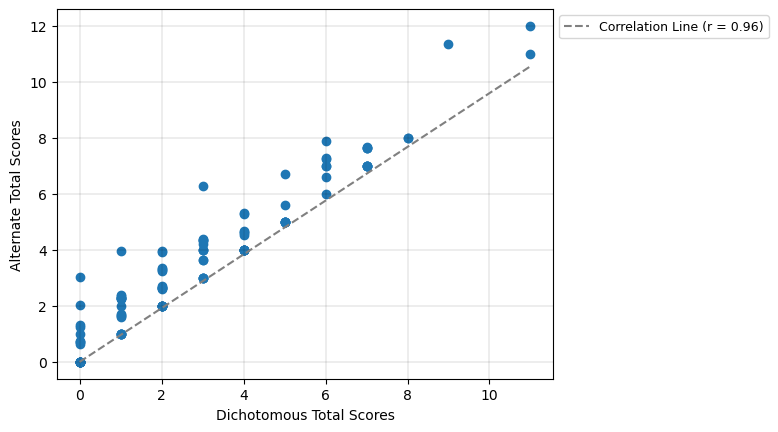

In [356]:

plt.scatter(merged_df['dich'], merged_df['myscore'], cmap='viridis')
# Adding a correlation line
correlation_coefficient0 = np.corrcoef(merged_df['myscore'], merged_df['dich'])[0, 1]
x_line = np.linspace(min(merged_df['dich']), max(merged_df['dich']), 100)
y_line = correlation_coefficient0 * x_line
plt.plot(x_line, y_line, color='gray', linestyle='dashed', label=f'Correlation Line (r = {correlation_coefficient0:.2f})')




# Adding labels and title
plt.xlabel('Dichotomous Total Scores')
plt.ylabel('Alternate Total Scores')
#plt.title('Total Scores Scatter Plot with Correlation Line')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

In [68]:
merged_df.loc[:, 'diff'].mean()

0.6478883244421171

In [260]:
diff_1ormore = merged_df[merged_df['diff']>=1].shape[0]

In [70]:
rank_change = merged_df['ranking_difference'].max()
max_rank_myscore = merged_df['rank_myscore'].max()
max_rank_dich = merged_df['rank_dich'].max()

In [261]:
print(f"{diff_in_score} participants out of 115 have different scores ({(diff_in_score/115)*100}%).")
print(f"{diff_1ormore} participants gained at least 1 point ({(diff_1ormore/115)*100}%).")
print(f"The maximal rank change is by {rank_change} rank spots up ({(rank_change/max_rank_dich)*100}%).")

65 participants out of 115 have different scores (56.52173913043478%).
39 participants gained at least 1 point (33.91304347826087%).
The maximal rank change is by 34 rank spots up (35.41666666666667%).


In [262]:
merged_df.sort_values(by=['diff'],ascending=False)

,Participant ID,dich,myscore,diff,rank_dich,rank_myscore,ranking_difference
107,f3ec3ef78890e0e8d8585993d00619ff,3.0,6.275935,3.275935,44,22,22
26,2fa82d49d17c033cfae57b188ec39fdb,0.0,3.047047,3.047047,96,62,34
16,14fc815e9aba716f210f98f1d0b1f5ba,1.0,3.962509,2.962509,78,54,24
11,12d05c94db983606f58d5b78354864d6,9.0,11.345245,2.345245,3,2,1
58,78bf377347ea63e43aed6f0ad22931fa,0.0,2.043020,2.043020,96,80,16
...,...,...,...,...,...,...,...
52,6e60988e9b62b2759fbdfefac7c6707c,8.0,8.000000,0.000000,4,4,0
51,6d6eb1e1a935fcb8081444829a5bab0d,7.0,7.000000,0.000000,6,13,-7
49,62ecf29ebac0ca0123e8f33a4789ebc7,2.0,2.000000,0.000000,59,81,-22
47,60d501c1c53ca74430e7bdf604a6cc96,0.0,0.000000,0.000000,96,105,-9


#### d. detailed item analysis

In [73]:
import numpy as np

In [175]:
#participant responses values count for each item 
response_counts = ans['RAT item'].value_counts().rename_axis('RAT item').reset_index(name='counts')
response_counts

,RAT item,counts
0,1,115
1,10,115
2,16,115
3,15,115
4,14,115
5,13,115
6,12,115
7,2,115
8,11,115
9,9,115


In [186]:
#correct responses (according to the algorithm) values count for each item 
fully_correct_ans = ans[ans['myscore']==1]
fully_correct_ans_counts = fully_correct_ans['RAT item'].value_counts().rename_axis('RAT item').reset_index(name='counts')
fully_correct_ans_counts.sort_values("RAT item")

,RAT item,counts
6,1,20
1,2,45
7,3,18
16,4,6
2,5,42
3,6,36
17,7,6
14,8,9
12,9,10
5,10,24


In [198]:
#correct responses (according to the algorithm) values count for each item 
partly_correct_ans = ans[(ans['myscore']>0) & (ans['myscore']<1)]
partly_correct_ans_counts = partly_correct_ans['RAT item'].value_counts().rename_axis('RAT item').reset_index(name='counts')
partly_correct_ans_counts.sort_values("RAT item")

,RAT item,counts
0,1,17
9,2,3
15,3,1
6,4,7
2,5,9
13,6,1
1,7,14
12,9,2
4,10,8
14,11,1


### Lower answers and cleaninng

In [76]:
outof3 = ans[(ans['Points']<1.0) & (ans['Points']> 0)]
outof3['response_lower'] = outof3['Response'].str.lower()
outof3

/var/folders/9g/4fg9x31x4cq2_th38fq9vtcw0000gn/T/ipykernel_33935/756607498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outof3['response_lower'] = outof3['Response'].str.lower()


,Participant ID,Condition,RAT item,RT,Response,Points,Tables,3rd prompt,3rd word,dist,response_lower
41,665057040db90d07f35fc81a5e1091db,Hightech,4,20000,Eis,0.636356,cue1 and cue2,item3,Welt,0.136356,eis
65,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,7,7653,Verkehr,0.628483,cue1 and cue2,item3,Bau,0.128483,verkehr
70,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,12,15012,Staub,0.656541,cue2 and cue3,item1,Werk,0.156541,staub
99,34d687b6484a52291330875f06d969b4,Hightech,1,8082,Tier,0.639816,cue1 and cue3,item2,Tasche,0.139816,tier
111,34d687b6484a52291330875f06d969b4,Hightech,13,3939,Kind,0.709715,cue1 and cue2,item3,Kissen,0.209715,kind
...,...,...,...,...,...,...,...,...,...,...,...
2190,8a0550ce35d183808d5c289d0fc4dda1,Pop,5,17655,Forschung,0.641725,cue1 and cue2,item3,Kurs,0.141725,forschung
2206,873152e1c8a4aaf0363954a0e29fa6da,Pop,4,6807,Reise,0.631563,cue1 and cue3,item2,Tüte,0.131563,reise
2209,873152e1c8a4aaf0363954a0e29fa6da,Pop,7,16604,Verkehr,0.628483,cue1 and cue2,item3,Bau,0.128483,verkehr
2222,0f31a434ceb8ed147c4bb605065331bd,Pop,1,5206,TIER,0.639816,cue1 and cue3,item2,Tasche,0.139816,tier


In [77]:
changecount = outof3['RAT item'].value_counts().rename_axis('RAT item').reset_index(name='counts')
changecount

,RAT item,counts
0,1,17
1,7,14
2,5,9
3,21,9
4,10,8
5,18,8
6,4,7
7,13,6
8,15,5
9,2,3


In [78]:
help_counts = pd.merge(correct, changecount, left_on='item order experiment', right_on='RAT item', how='left')

# Dropping unnecessary columns if needed
help_counts = help_counts.drop(['correct answer', 'item1', 'item2', 'item3','answers', '2outof3', 'RAT item'], axis=1)
help_counts

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",counts
0,1,RAT_19,33,17.0
1,2,RAT_1,9,3.0
2,3,RAT_7,31,1.0
3,4,RAT_13,57,7.0
4,5,RAT_2,15,9.0
5,6,RAT_8,18,1.0
6,7,RAT_14,59,14.0
7,8,RAT_3,35,NaN
8,9,RAT_9,17,2.0
9,10,RAT_15,24,8.0


In [79]:
print(help_counts['time to solution (s) (Landmann et el., 2014)'].corr(help_counts['counts']))

0.24043085603264291


## Participants

In [80]:
# Grouping by column 'Participant ID' and counting occurrences while preserving 'Condition'
part_gr = outof3.groupby('Participant ID')['Condition'].value_counts().reset_index(name='count')
part_gr.sort_values('count', ascending=False).head(10)

,Participant ID,Condition,count
52,f3ec3ef78890e0e8d8585993d00619ff,Hightech,5
14,2fa82d49d17c033cfae57b188ec39fdb,Pop,5
28,78bf377347ea63e43aed6f0ad22931fa,Hightech,3
42,caa9c90b4bc32bd7580af1b4f55af2bb,Hightech,3
15,33aee10d5c5c43c0f16e27f2e842b3dc,Pop,3
11,16ffb7d07052323a8ae16265184d925f,Hightech,3
10,14fc815e9aba716f210f98f1d0b1f5ba,Hightech,3
45,d66c7ffa25fbe67aec68ea1c8ab8fc04,Hightech,2
48,dbe08c41dd0a3fd57228fcf4ee433b56,Hightech,2
39,b4cc70a28491162b1d2938e8556ce562,Pop,2


## Condition

In [81]:
#out of the 2/3 how many of the items were from Hightech and from Pop
outof3['Condition'].value_counts()

Condition
Hightech    58
Pop         40
Name: count, dtype: int64

In [82]:
#ans.groupby('Participant ID')['Points'].sum()
#condition

grouped_multiple = ans.groupby(['Participant ID', 'Condition']).agg({'Points': ['sum']})
grouped_multiple.columns = ['sum']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple

,Participant ID,Condition,sum
0,008593819a6b1a5a99b48aeb17d2844d,Hightech,4.307943
1,03db908beef29f3b8e2a2c602b9bebdc,Pop,4.000000
2,046a9ecd793e58722934cf118ebb74b4,Pop,0.000000
3,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,5.285023
4,07a84f9a994927d4bc940f2f1bc92946,Pop,6.709715
...,...,...,...
110,f7d86520884c4a0e8f4b8f36940957ea,Pop,0.709715
111,f910c0532dba0f0f232d595130bcf11a,Hightech,2.602010
112,f9ed2e8f1d6b7c11fe95845abd3e0571,Pop,0.000000
113,fd7a41ae808f2626da8b06dd579a061a,Hightech,4.528379


In [83]:
grouped_multiple.groupby('Condition')['sum'].median()

Condition
Hightech    3.963321
Pop         3.047047
Name: sum, dtype: float64

In [84]:
#dichonomous scoring
dich_multiple = ans1p.groupby(['Participant ID', 'Condition']).agg({'Points': ['sum']})
dich_multiple.columns = ['sum']
dich_multiple = dich_multiple.reset_index()

#dich_multiple.sort_values(by=['Points'],ascending=False)

In [85]:
dich_multiple.groupby('Condition')['sum'].median()

Condition
Hightech    2.5
Pop         3.0
Name: sum, dtype: float64

In [201]:
outof3

,Participant ID,Condition,RAT item,RT,Response,Points,Tables,3rd prompt,3rd word,dist,response_lower
41,665057040db90d07f35fc81a5e1091db,Hightech,4,20000,Eis,0.636356,cue1 and cue2,item3,Welt,0.136356,eis
65,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,7,7653,Verkehr,0.628483,cue1 and cue2,item3,Bau,0.128483,verkehr
70,05d5ef939d53aacdcda4ec2b1a2dcfd4,Hightech,12,15012,Staub,0.656541,cue2 and cue3,item1,Werk,0.156541,staub
99,34d687b6484a52291330875f06d969b4,Hightech,1,8082,Tier,0.639816,cue1 and cue3,item2,Tasche,0.139816,tier
111,34d687b6484a52291330875f06d969b4,Hightech,13,3939,Kind,0.709715,cue1 and cue2,item3,Kissen,0.209715,kind
...,...,...,...,...,...,...,...,...,...,...,...
2190,8a0550ce35d183808d5c289d0fc4dda1,Pop,5,17655,Forschung,0.641725,cue1 and cue2,item3,Kurs,0.141725,forschung
2206,873152e1c8a4aaf0363954a0e29fa6da,Pop,4,6807,Reise,0.631563,cue1 and cue3,item2,Tüte,0.131563,reise
2209,873152e1c8a4aaf0363954a0e29fa6da,Pop,7,16604,Verkehr,0.628483,cue1 and cue2,item3,Bau,0.128483,verkehr
2222,0f31a434ceb8ed147c4bb605065331bd,Pop,1,5206,TIER,0.639816,cue1 and cue3,item2,Tasche,0.139816,tier


### RAT item 1

In [227]:
item1 = outof3[outof3['RAT item']==1]


# Count occurrences of values in 'response_lower' 
result_counts1 = item1['response_lower'].value_counts().reset_index()
result_counts1.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts1 = pd.merge(result_counts1, item1[['response_lower', '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts1['dist']= counts1['dist']*2
counts1.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
16,weste,1,Pelz,0.431679,0.715840
0,tier,13,Tasche,0.279632,0.639816
13,hand,3,Pelz,0.208017,0.604009


### RAT item 2

In [228]:
item2 = outof3[outof3['RAT item']==2]

# Count occurrences of values in 'response_lower' 
result_counts2 = item2['response_lower'].value_counts().reset_index()
result_counts2.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts2 = pd.merge(result_counts2, item2[['response_lower', '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts2['dist']= counts2['dist']*2
counts2.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,kanne,3,Porzellan,0.340945,0.670473


### RAT item 3

In [382]:
item3 = outof3[outof3['RAT item']==3]

# Count occurrences of values in 'response_lower' 
result_counts3 = item3['response_lower'].value_counts().reset_index()
result_counts3.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts3 = pd.merge(result_counts3, item3[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts3['dist']= counts3['dist']*2
counts3.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,personal,1,Rundfahrt,0.111824,0.555912


### RAT item 4

In [383]:
item4 = outof3[outof3['RAT item']==4]

# Count occurrences of values in 'response_lower' 
result_counts4 = item4['response_lower'].value_counts().reset_index()
result_counts4.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts4 = pd.merge(result_counts4, item4[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts4['dist']= counts4['dist']*2
counts4.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
4,farbe,1,Tüte,0.416270,0.708135
5,bild,1,Tüte,0.321205,0.660602
6,schule,1,Natur,0.287290,0.643645
0,eis,2,Welt,0.272713,0.636356
2,reise,2,Tüte,0.263126,0.631563


### RAT item 5

In [384]:
item5 = outof3[outof3['RAT item']==5]

# Count occurrences of values in 'response_lower' 
result_counts5 = item5['response_lower'].value_counts().reset_index()
result_counts5.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts5 = pd.merge(result_counts5, item5[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts5['dist']= counts5['dist']*2
counts5.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
7,system,1,Virus,0.374265,0.687132
8,pc,1,Virus,0.335610,0.667805
2,forschung,2,Kurs,0.283449,0.641725
6,inhalt,1,Virus,0.217413,0.608706
4,sport,2,Virus,0.208073,0.604036
0,raum,2,Virus,0.056758,0.528379


### RAT item 6

In [385]:
item6 = outof3[outof3['RAT item']==6]

# Count occurrences of values in 'response_lower' 
result_counts6 = item6['response_lower'].value_counts().reset_index()
result_counts6.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts6 = pd.merge(result_counts6, item6[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts6['dist']= counts6['dist']*2
counts6.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,sport,1,Hagel,0.233065,0.616532


### RAT item 7

In [386]:
item7 = outof3[outof3['RAT item']==7]

# Count occurrences of values in 'response_lower' 
result_counts7 = item7['response_lower'].value_counts().reset_index()
result_counts7.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts7 = pd.merge(result_counts7, item7[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts7['dist']= counts7['dist']*2
counts7.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
4,autobahn,2,Bahn,0.494697,0.747349
11,land,1,Schild,0.417298,0.708649
10,haus,1,Bahn,0.412150,0.706075
12,berg,1,Schild,0.326204,0.663102
8,stadt,1,Schild,0.315841,0.657920
7,hof,1,Schild,0.315405,0.657703
9,weg,1,Schild,0.290430,0.645215
0,verkehr,4,Bau,0.256965,0.628483
13,eis,1,Bau,0.195038,0.597519
6,station,1,Bau,0.180512,0.590256


### RAT item 9

In [387]:
item9 = outof3[outof3['RAT item']==9]

# Count occurrences of values in 'response_lower' 
result_counts9 = item9['response_lower'].value_counts().reset_index()
result_counts9.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts9 = pd.merge(result_counts9, item9[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts9['dist']= counts9['dist']*2
counts9.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,apfel,1,Minze,0.410857,0.705429
1,mutter,1,Minze,0.240951,0.620476


### RAT item 10

In [388]:
item10 = outof3[outof3['RAT item']==10]

# Count occurrences of values in 'response_lower' 
result_counts10 = item10['response_lower'].value_counts().reset_index()
result_counts10.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts10 = pd.merge(result_counts10, item10[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts10['dist']= counts10['dist']*2
counts10.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,schwert,5,Block,0.275205,0.637602
7,papier,1,Klinge,0.209528,0.604764
5,berg,2,Klinge,0.204020,0.602010


### RAT item 11

In [389]:
item11 = outof3[outof3['RAT item']==11]

# Count occurrences of values in 'response_lower' 
result_counts11 = item11['response_lower'].value_counts().reset_index()
result_counts11.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts11 = pd.merge(result_counts11, item11[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts11['dist']= counts11['dist']*2
counts11.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,körper,1,Ausschlag,0.415095,0.707548


### RAT item 12

In [408]:
item12 = outof3[outof3['RAT item']==12]
# Count occurrences of values in 'response_lower' 
result_counts12 = item12['response_lower'].value_counts().reset_index()
result_counts12.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts12 = pd.merge(result_counts12, item12[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts12['dist']= counts12['dist']*2
counts12.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
2,papier,1,Mehl,0.449109,0.724555
1,kunst,1,Mehl,0.319103,0.659551
0,staub,1,Werk,0.313081,0.656541


### RAT item 13

In [391]:
item13 = outof3[outof3['RAT item']==13]
# Count occurrences of values in 'response_lower' 
result_counts13 = item13['response_lower'].value_counts().reset_index()
result_counts13.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts13 = pd.merge(result_counts13, item13[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts13['dist']= counts13['dist']*2
counts13.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,kind,6,Kissen,0.419429,0.709715


### RAT item 14

In [392]:
item14 = outof3[outof3['RAT item']==14]

# Count occurrences of values in 'response_lower' 
result_counts14 = item14['response_lower'].value_counts().reset_index()
result_counts14.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts14 = pd.merge(result_counts14, item14[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts14['dist']= counts14['dist']*2
counts14.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,video,1,Heft,0.236352,0.618176


### RAT item 15

In [393]:
item15 = outof3[outof3['RAT item']==15]

# Count occurrences of values in 'response_lower' 
result_counts15 = item15['response_lower'].value_counts().reset_index()
result_counts15.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts15 = pd.merge(result_counts15, item15[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts15['dist']= counts15['dist']*2
counts15.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,bild,5,Finsternis,0.304442,0.652221


### RAT item 17

In [394]:
item17 = outof3[outof3['RAT item']==17]

# Count occurrences of values in 'response_lower' 
result_counts17 = item17['response_lower'].value_counts().reset_index()
result_counts17.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts17 = pd.merge(result_counts17, item17[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts17['dist']= counts17['dist']*2
counts17.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,arbeit,2,Gefäß,0.270688,0.635344
2,test,1,Gefäß,0.266045,0.633023


### RAT item 18

In [395]:
item18 = outof3[outof3['RAT item']==18]

# Count occurrences of values in 'response_lower' 
result_counts18 = item18['response_lower'].value_counts().reset_index()
result_counts18.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts18 = pd.merge(result_counts18, item18[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts18['dist']= counts18['dist']*2
counts18.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
0,haus,7,Pfahl,0.340682,0.670341
7,familie,1,Pfahl,0.214786,0.607393


### RAT item 21

In [396]:
item21 = outof3[outof3['RAT item']==21]

# Count occurrences of values in 'response_lower' 
result_counts21 = item21['response_lower'].value_counts().reset_index()
result_counts21.columns = ['response_lower', 'count']

# Merge with the original DataFrame to include values from 'y'
counts21 = pd.merge(result_counts21, item21[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

#print(counts1)
counts21['dist']= counts21['dist']*2
counts21.sort_values("dist", ascending=False)

,response_lower,count,3rd word,dist,Points
3,arbeit,2,Verletzung,0.316894,0.658447
0,zeit,3,Verletzung,0.295506,0.647753
8,training,1,Verletzung,0.278453,0.639227
5,unfall,2,Probe,0.255021,0.627511
7,krieg,1,Probe,0.232512,0.616256


In [400]:
dfs = [counts1,counts2,counts3,counts4,counts5,counts6,counts7,counts9,counts10,counts11,counts12,counts13,counts14,counts15,counts17,counts18,counts21]  # Add all your dataframes here

# Create a function to append the name of the dataframe as a new column
def append_df_name(df, name):
    df['DataFrame'] = name
    return df

# Append the dataframes together and add the DataFrame name as a new column
combined_df = pd.concat([append_df_name(df, name) for name, df in enumerate(dfs, start=1)], ignore_index=True)

combined_df

,response_lower,count,3rd word,dist,Points,DataFrame
0,tier,13,Tasche,0.279632,0.639816,1
1,hand,3,Pelz,0.208017,0.604009,1
2,weste,1,Pelz,0.431679,0.715840,1
3,kanne,3,Porzellan,0.340945,0.670473,2
4,personal,1,Rundfahrt,0.111824,0.555912,3
5,eis,2,Welt,0.272713,0.636356,4
6,reise,2,Tüte,0.263126,0.631563,4
7,farbe,1,Tüte,0.416270,0.708135,4
8,bild,1,Tüte,0.321205,0.660602,4
9,schule,1,Natur,0.287290,0.643645,4


In [406]:
combined_df.to_excel("2outof3counttable.xlsx")  

## think about automising 

def generate_X(item):
    # Count occurrences of values in 'response_lower' 
    result_counts = item['response_lower'].value_counts().reset_index()
    result_counts.columns = ['response_lower', 'count']

    # Merge with the original DataFrame to include values from 'y'
    counts = pd.merge(result_counts, item[['response_lower',  '3rd word', 'dist', 'Points']], on='response_lower').drop_duplicates()

    counts['dist'] = counts['dist'] * 2
    X = counts.sort_values("dist", ascending=False)
    
    return X

Example usage:
Assuming you have already defined 'outof3' DataFrame and 'item21' is extracted from it
X_21 = generate_X(item21)


### Descriptive statistics

In [104]:
ans1p

,Participant ID,Condition,RAT item,RT,Response,Points
0,f2b31ae7802d6acebf334468f14c2e59,Hightech,1,10463,Jacke,0.0
1,f2b31ae7802d6acebf334468f14c2e59,Hightech,2,8792,Schrank,0.0
2,f2b31ae7802d6acebf334468f14c2e59,Hightech,3,5695,Ziel,0.0
3,f2b31ae7802d6acebf334468f14c2e59,Hightech,4,13271,Pflanze,0.0
4,f2b31ae7802d6acebf334468f14c2e59,Hightech,5,13117,Technik,0.0
...,...,...,...,...,...,...
2295,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,17,5435,nan,0.0
2296,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,18,2041,nan,0.0
2297,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,19,12532,nan,0.0
2298,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,20,20000,nan,0.0


In [105]:
ans = pd.merge(ans, ans1p[['Participant ID', 'RAT item', 'Points']], on=['Participant ID', 'RAT item'])
ans = ans.rename(columns={"Points_x": "myscore", "Points_y": "dich"}, errors="raise")
ans

,Participant ID,Condition,RAT item,RT,Response,myscore,Tables,3rd prompt,3rd word,dist,dich
0,f2b31ae7802d6acebf334468f14c2e59,Hightech,1,10463,Jacke,1.0,NaN,NaN,NaN,NaN,0.0
1,f2b31ae7802d6acebf334468f14c2e59,Hightech,2,8792,Schrank,0.0,NaN,NaN,NaN,NaN,0.0
2,f2b31ae7802d6acebf334468f14c2e59,Hightech,3,5695,Ziel,0.0,NaN,NaN,NaN,NaN,0.0
3,f2b31ae7802d6acebf334468f14c2e59,Hightech,4,13271,Pflanze,0.0,NaN,NaN,NaN,NaN,0.0
4,f2b31ae7802d6acebf334468f14c2e59,Hightech,5,13117,Technik,0.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2295,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,17,5435,nan,0.0,NaN,NaN,NaN,NaN,0.0
2296,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,18,2041,nan,0.0,NaN,NaN,NaN,NaN,0.0
2297,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,19,12532,nan,0.0,NaN,NaN,NaN,NaN,0.0
2298,f389ce3b9e9e1210d425bfa7b0988ae8,Pop,20,20000,nan,0.0,NaN,NaN,NaN,NaN,0.0


In [106]:
per_item = ans.groupby(['RAT item']).agg({'myscore': ['mean', 'std'],'dich': ['mean','std']})
per_item.columns = ['mean myscore', 'std myscore', 'mean dich', 'std dich']
per_item = per_item.reset_index()
per_item.round(2)

,RAT item,mean myscore,std myscore,mean dich,std dich
0,1,0.27,0.40,0.13,0.34
1,2,0.41,0.49,0.39,0.49
2,3,0.16,0.37,0.16,0.36
3,4,0.09,0.26,0.05,0.22
4,5,0.41,0.48,0.37,0.48
5,6,0.32,0.47,0.31,0.47
6,7,0.13,0.30,0.01,0.09
7,8,0.08,0.27,0.08,0.27
8,9,0.10,0.29,0.09,0.28
9,10,0.25,0.42,0.20,0.40


In [107]:
table1

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",item,correct answer
0,1,RAT_19,33,Pelz - Tasche - Schutz,Mantel
1,2,RAT_1,9,Kaffee - Schnabel - Porzellan,Tasse
2,3,RAT_7,31,Plan - Rundfahrt - Rat,Stadt
3,4,RAT_13,57,Natur - Tüte - Welt,Wunder
4,5,RAT_2,15,Programm - Virus - Kurs,Computer
5,6,RAT_8,18,Welt - Hagel - Billard,Kugel
6,7,RAT_14,59,Schild - Bahn - Bau,Straße
7,8,RAT_3,35,Elch - Aids - Pilot,Test
8,9,RAT_9,17,Minze - Korn - Kuchen,Pfeffer
9,10,RAT_15,24,Block - Klinge - Spitze,Messer


In [332]:
final = pd.merge(table1, per_item[['RAT item','mean myscore', 'std myscore', 'mean dich', 'std dich']], left_on=['item order experiment'], right_on=['RAT item'])
final.drop(columns='RAT item')
final.sort_values("mean myscore", ascending=False)

,item order experiment,item name,"time to solution (s) (Landmann et el., 2014)",item,correct answer,RAT item,mean myscore,std myscore,mean dich,std dich
4,5,RAT_2,15,Programm - Virus - Kurs,Computer,5,0.413147,0.475459,0.365217,0.483598
1,2,RAT_1,9,Kaffee - Schnabel - Porzellan,Tasse,2,0.408795,0.487840,0.391304,0.490178
10,11,RAT_4,12,Falte - Ausschlag - Kontakt,Haut,11,0.397457,0.489664,0.391304,0.490178
5,6,RAT_8,18,Welt - Hagel - Billard,Kugel,6,0.318405,0.465675,0.313043,0.465761
0,1,RAT_19,33,Pelz - Tasche - Schutz,Mantel,1,0.268222,0.404527,0.130435,0.338255
18,19,RAT_6,6,Raps - Plattform - Preis,Öl,19,0.252632,0.436827,0.252632,0.436827
9,10,RAT_15,24,Block - Klinge - Spitze,Messer,10,0.252146,0.416879,0.200000,0.401751
2,3,RAT_7,31,Plan - Rundfahrt - Rat,Stadt,3,0.161356,0.366526,0.156522,0.364939
20,21,RAT_18,100,Tag - Verletzung - Probe,Stich,21,0.145831,0.308391,0.059701,0.238721
19,20,RAT_12,39,Joker - Kabel - Nummer,Telefon,20,0.134146,0.342907,0.134146,0.342907


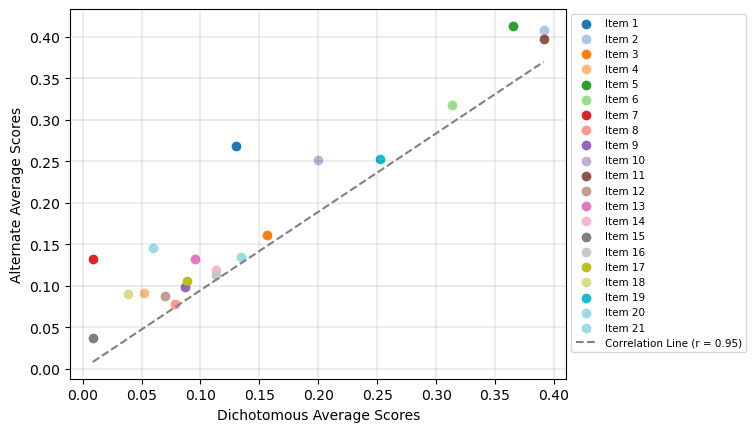

In [367]:
import matplotlib.pyplot as plt
# Create the scatter plot
#plt.scatter(final['mean myscore'], final['mean dich'], c=final['item order experiment'], cmap='viridis')
colors = plt.cm.tab20(np.linspace(0, 1, 21))

#plt.scatter(final['mean myscore'], final['mean dich'], c=final['item order experiment'], cmap='viridis', label='Item')
for item, x, y, color in zip(final['item order experiment'], final['mean dich'], final['mean myscore'],colors):
    plt.scatter(x, y, label=f'Item {item}', color=color)



x = range(0, 2)  
# Calculate and plot the correlation line
correlation_coefficient = np.corrcoef(final['mean dich'], final['mean myscore'])[0, 1]
x_line = np.linspace(min(final['mean dich']), max(final['mean dich']), 100)
y_line = correlation_coefficient * x_line
plt.plot(x_line, y_line, color='gray', linestyle='dashed', label=f'Correlation Line (r = {correlation_coefficient:.2f})')
#plt.plot(x, x, label='y=x', color='red')



# Set labels for the axes
plt.xlabel('Dichotomous Average Scores')
plt.ylabel('Alternate Average Scores')

# Set title for the graph
#plt.title('Average Score per Item Scatter Plot with Correlation Line')

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=7.5)

# Show the plot
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

In [350]:
final.to_excel("statistics_per_item.xlsx")  

In [112]:
dich = ans1p.groupby('Participant ID')['Points'].sum().reset_index()
dich.sort_values(by=['Points'],ascending=False)

,Participant ID,Points
24,2c0871ef20fa6709769e1a5c6d8e1297,11.0
61,824afedd52b13257c08650836cde7de0,11.0
11,12d05c94db983606f58d5b78354864d6,9.0
67,8c33a001348f1bc2722620f13fad0749,8.0
52,6e60988e9b62b2759fbdfefac7c6707c,8.0
...,...,...
78,ad5d7e416724ddb01516d53ca5d82de3,0.0
26,2fa82d49d17c033cfae57b188ec39fdb,0.0
18,16416b48802089c18709c956156c1c60,0.0
53,701b003f839ee0f80acac802e7156d79,0.0


In [250]:
mean_dich = merged_df['dich'].mean()
median_dich = merged_df['dich'].median()
mode_dich = merged_df['dich'].mode()

print(f'Mean dichotomous score is {mean_dich}')
print(f'Median dichotomous score is {median_dich}')
print(f'Mode in  dichotomous scores is {mode_dich}')

Mean dichotomous score is 3.034782608695652
Median dichotomous score is 3.0
Mode in  dichotomous scores is 0    0.0
Name: dich, dtype: float64


In [251]:
mean_myscore = merged_df['myscore'].mean()
median_myscore = merged_df['myscore'].median()
mode_myscore = merged_df['myscore'].mode()

print(f'Mean of the alternate score is {mean_myscore}')
print(f'Median of the alternate score is {median_myscore}')
print(f'Mode in  of the alternate scores is {mode_myscore}')

Mean of the alternate score is 3.682670933137769
Median of the alternate score is 3.3495306372642517
Mode in  of the alternate scores is 0    0.0
1    4.0
Name: myscore, dtype: float64
